# Example from Lee et. al. WRR (2018)

- This example tested with python 2.7 because we use a wrapper of AdH simulation written several years ago. We will update scripts in python 3.X.

- In python 2.X, psutil.cpu_count seems not working well, thus this example may not correctly identify your cpu core numbers automatically. Please check how many cores are used and set Param['ncores'] manually if not correctly defined. 

```
from psutil import cpu_count
print(cpu_count(logical=False))
```

To text this example notebook, you will need 

     - setup_savannah.py
     - adh.py
     - true.txt
     - obs.txt
     - AdH input directories mean_files, mesh_files, observation_files, sim_files, true_files

and ERDC's enkf_tools package.


- You can download the AdH inputs used in this notebook from https://github.com/jonghyunharrylee/adh_lee_et_al_wrr_2018

- Copy the AdH input directorys ( to your current directory.

- Place the excutable adh (and pre_adh) in the dirctory ./Bin/v4/ or ./Bin/v5/

- Example was run on a 48 Intel CPU core workstation.

- Please contact ERDC team (https://www.erdc.usace.army.mil/Media/Fact-Sheets/Fact-Sheet-Article-View/Article/476708/adaptive-hydraulics-model-system/) to access the AdH source code

J. Lee, H. Ghorbanidehno, M. Farthing, T. Hesser, E. F. Darve, and P. K. Kitanidis, Riverine bathymetry imaging with indirect observations, Water Resources Research, 54(5): 3704-3727, 2018


In [1]:
import sys
print(sys.version)

2.7.18 |Anaconda, Inc.| (default, Apr 23 2020, 22:42:48) 
[GCC 7.3.0]


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

from pyPCGA import PCGA

from multiprocessing import Pool
import math
from scipy.io import savemat, loadmat
import adh

Warning, using Archiver without full (e.g., parallel) capabilities, need proteus for full functionality
trying to import archiver


In [3]:
print(np.__version__)

1.16.5


- Simulation parameters to use

In [4]:
sim_params = {'sim_dir':'./simul',
            'adh_exec':'./bin/v4/adh',
            'pre_adh_exec':'./bin/v4/pre_adh',
            'adh_version':4.5,
            'adh_ntsim': 1,
            'Q_b' : 6873.5,
            'z_f' : 97.14,
            'adh_grid':'./mesh_files/grid_savannah_river_nx501_ny41',
            'adh_rect':'./mesh_files/rect_savannah_river_nx501_ny41',
            'adh_mesh':'./sim_files/savannah_gridgen_new_nx501_ny41.3dm',
            'adh_bc':'./sim_files/savannah_gridgen_new_nx501_ny41.bc',
            'velocity_obs_file':'./observation_files/observation_loc_drogue12345_50ft.dat',
            'elevation_obs_file':'./observation_files/observation_loc_none.dat', 
            'true_soln_file_h5':'./true_files/savannah_gridgen_true_nx501_ny41_p0.h5',
            'true_soln_meshbase':'./true_files/savannah_gridgen_true_nx501_ny41'
            }

- Load files fro mesh info and visualization

In [5]:
s_true = np.loadtxt('true.txt').reshape(-1, 1) #'./mesh_files/mesh_files/savannah_river_'  
obs = np.loadtxt('obs.txt').reshape(-1, 1)

triangles = np.loadtxt('triangles.txt')
meshnode = np.loadtxt('meshnode.txt')

In [6]:
velocity_obs_loc = np.loadtxt("observation_files/observation_loc_drogue12345_50ft.dat")

- Define the domain

In [7]:
nx = 501
ny = 41

N = np.array([nx, ny])
m = np.prod(N)
dx = np.array([1., 1.])

x = np.linspace(0., 501., N[0])
y = np.linspace(0., 41., N[1])

xmin = np.array([x[0], y[0]])
xmax = np.array([x[-1], y[-1]])

- Define the prior covariance kernel (Gaussian) and scale parameters

In [8]:
prior_std = 3.3 # ft 
prior_cov_scale = np.array([48., 12.]) # cells in the transformed domain

In [9]:
def kernel(r): return (prior_std ** 2) * np.exp(-r ** 2)

In [10]:
XX, YY = np.meshgrid(x, y)
pts = np.hstack((XX.ravel()[:, np.newaxis], YY.ravel()[:, np.newaxis])) # don't need this, pts=None is OK

- Set initial point for iterations; the final result would be the same regardless of this input

In [11]:
s_init = np.mean(s_true) * np.ones((m, 1))

- Prepare interface to run as a function

In [12]:
def forward_model(s, parallelization, ncores=None):
    mymodel = adh.Model(sim_params)

    if parallelization:
        if ncores is None:
            from psutil import cpu_count  # physcial cpu counts
            ncores = cpu_count(logical=False)
        simul_obs = mymodel.run(s, parallelization, ncores)
    else:
        simul_obs = mymodel.run(s, parallelization)

    if simul_obs.ndim == 1:
        simul_obs = simul_obs.reshape(-1, 1)

    return simul_obs

Define pyPCGA parameters

In [13]:
params = {'R': (0.17) ** 2, 'n_pc': 50,
          'maxiter': 5, 'restol': 1e-2,
          'matvec': 'FFT', 'xmin': xmin,
          'xmax': xmax, 'N': N,
          'prior_std': prior_std, 'prior_cov_scale': prior_cov_scale,
          'kernel': kernel, 'post_cov': True, 'precond': True,
          'parallel': True, 'LM': True, # 'LM_smin' : 60.0, 'LM_smax' : 105.0,
          'linesearch': True,
          'forward_params': sim_params,
          'forward_model_verbose': False, 'verbose': True,
          'iter_save': True #, 'ncores': 48
          }
# params['objeval'] = False, if true, it will compute accurate objective function
# params['ncores'] = 48, with parallell True, it will determine maximum physcial core unless specified


- Initialize PCGA

In [14]:
prob = PCGA(forward_model, s_init, pts, params, s_true, obs)
# prob = PCGA(forward_model, s_init, pts, params, s_true, obs, X = X) #if you want to add your own drift X

##### PCGA Inversion #####
##### 1. Initialize forward and inversion parameters
------------ Inversion Parameters -------------------------
   Number of unknowns                               : 20541
   Number of observations                           : 816
   Number of principal components (n_pc)            : 50
   Prior model                                      : def kernel(r): return (prior_std ** 2) * np.exp(-r ** 2)

   Prior variance                                   : 1.089000e+01
   Prior scale (correlation) parameter              : [48. 12.]
   Posterior cov computation                        : True
   Posterior variance computation                   : Approx.
   Number of CPU cores (n_core)                     : 48
   Maximum GN iterations                            : 5
   machine precision (delta = sqrt(precision))      : 1.000000e-08
   Tol for iterations (norm(sol_diff)/norm(sol))    : 1.000000e-02
   Levenberg-Marquardt (LM)                         : True
   LM solution 

- Run inversion

In [15]:
s_hat, simul_obs, post_diagv, iter_best = prob.Run()

##### 2. Construct Prior Covariance Matrix
- time for covariance matrix construction (m = 20541) is 0 sec
##### 3. Eigendecomposition of Prior Covariance
- time for eigendecomposition with k = 50 is 1 sec
- 1st eigv : 16501.1, 50-th eigv : 529.206, ratio: 0.032071
##### 4. Start PCGA Inversion #####
-- evaluate initial solution


adh.py:104: UserWarning: loadtxt: Empty input file: "./observation_files/observation_loc_none.dat"
  elev_obs_loc = np.loadtxt(self.elevation_obs_file)


obs. RMSE (norm(obs. diff.)/sqrt(nobs)): 0.265284, normalized obs. RMSE (norm(obs. diff./sqrtR)/sqrt(nobs)): 1.56049
***** Iteration 1 ******
computed Jacobian-Matrix products in 773.470695 secs
eig. val. of generalized data covariance : 0.017185 secs (5.48e-02, 5.48e-02, 3.51e+00)
time for data covarance construction : 0.018993 sec 
eig. val. of data covariance (5.49e+02, 8.11e-02, 5.49e+02)
solve saddle point (co-kriging) systems with Levenberg-Marquardt
-- Number of iterations for gmres 1
0 - min(s): 80.1867, max(s) :93.17
-- Number of iterations for gmres 1
1 - min(s): 80.2172, max(s) :93.0936
-- Number of iterations for gmres 1
2 - min(s): 80.251, max(s) :93.011
-- Number of iterations for gmres 1
3 - min(s): 80.2886, max(s) :92.9217
-- Number of iterations for gmres 1
4 - min(s): 80.3294, max(s) :92.8281
-- Number of iterations for gmres 1
5 - min(s): 80.3744, max(s) :92.7332
-- Number of iterations for gmres 1
6 - min(s): 80.4241, max(s) :92.6302
-- Number of iterations for gmre

LM solution evaluted
48 objective value evaluations
0-th solution obj [405.15825067] (alpha 1.0, beta [12496.591831012704])
1-th solution obj [405.08074088] (alpha 1.15832328625, beta [12494.329285569085])
2-th solution obj [405.07637233] (alpha 1.34171283548, beta [12492.10446637427])
- Geostat. inversion at iteration 2 is 1261 sec
== iteration 2 summary ==
= objective function is 4.050764e+02, relative L2-norm diff btw sol 1 and sol 2 is 0.0095973
= L2-norm error (w.r.t truth) is 0.0254719, obs. RMSE is 0.166801, obs. normalized RMSE is 0.981182
- save results in text at iteration 2
start posterior variance computation
10000-th element evalution done..
20000-th element evalution done..
posterior diag. computed in 4.267882 secs
------------ Inversion Summary ---------------------------
** Found solution at iteration 2
** Solution obs. RMSE 0.166801 , initial obs. RMSE 0.265284, where RMSE = (norm(obs. diff.)/sqrt(nobs)), Solution obs. nRMSE 0.981182, init. obs. nRMSE 1.56049
** Final 

- You can save results for model validation and post-processing e.g, posterior realization generation

In [16]:
savemat('results.mat', {'s_hat': s_hat, 'simul_obs': simul_obs,
                        'iter_best': iter_best,
                        'objvals': prob.objvals, 'R': prob.R,
                        'n_pc': prob.n_pc,'matvec':prob.matvec,
                        'prior_std': params['prior_std'], 'prior_cov_scale': params['prior_cov_scale'],
                        'LM': prob.LM, 'linesearch': prob.linesearch,
                        'Q2': prob.Q2_best, 'cR': prob.cR_best,
                        'maxiter': prob.maxiter, 'i_best': prob.i_best,
                        'restol': prob.restol, 'diagv': post_diagv})

Go ahead and save the last solution to a file (intermediate solutions were saved as 'shat0X.txt')

In [17]:
np.savetxt('shat.txt',s_hat)

In [18]:
s_hat2d = s_hat.reshape(N[1], N[0])
s_true2d = s_true.reshape(N[1], N[0])
minv = s_true.min()
maxv = s_true.max()

In [19]:
velocity_obs_loc = np.loadtxt(sim_params['velocity_obs_file'])

In [20]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

Text(0.5,1,'True Savannah Bathymetry')

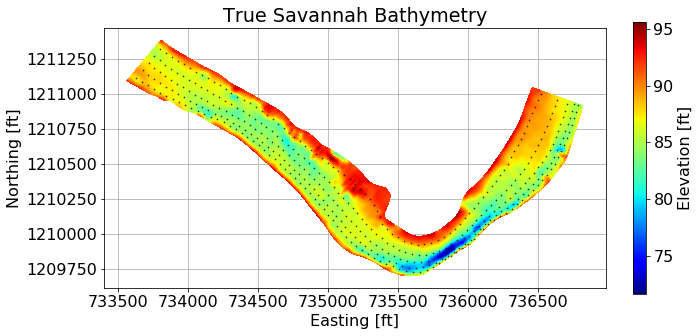

In [22]:
#fig = plt.figure(figsize=(10., 10.), dpi=300)
fig = plt.figure(figsize=(10., 10.))
ax = plt.gca()
im = plt.tripcolor(meshnode[:, 0], meshnode[:, 1], triangles, meshnode[:, 2], cmap=plt.get_cmap('jet'), vmin = minv, vmax = maxv, label='_nolegend_')
ax.set_xlabel("Easting [ft]")
ax.set_ylabel("Northing [ft]")
plt.gca().set_aspect('equal', adjustable='box')
cbar = plt.colorbar(im, fraction=0.025, pad=0.05)
cbar.set_label('Elevation [ft]')
plt.scatter(velocity_obs_loc[:, 0], velocity_obs_loc[:, 1], c='k', s=0.5, alpha=0.7, label='obs.')
plt.rcParams['axes.axisbelow'] = True
plt.rc('axes', axisbelow=True)
plt.grid()
ax.set_axisbelow(True)
plt.tight_layout()
ax.set_title('True Savannah Bathymetry')
#plt.savefig('./bathymetry_true.png', dpi=300, bbox_inches='tight', pad_inches=0.0)
# plt.show()
#plt.close(fig)


Text(0.5,1,'Estimated Savannah Bathymetry')

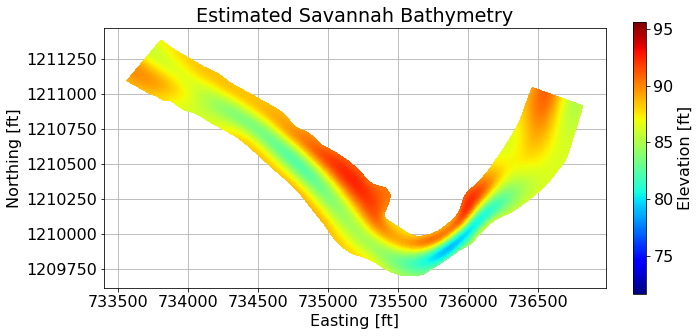

In [23]:
#fig = plt.figure(figsize=(10., 10.), dpi=300)
fig = plt.figure(figsize=(10., 10.))
ax = plt.gca()
im = plt.tripcolor(meshnode[:, 0], meshnode[:, 1], triangles, s_hat.reshape(-1), cmap=plt.get_cmap('jet'),vmin = minv, vmax = maxv, label='_nolegend_')                
ax.set_xlabel("Easting [ft]")
ax.set_ylabel("Northing [ft]")
plt.gca().set_aspect('equal', adjustable='box')
cbar = plt.colorbar(im, fraction=0.025, pad=0.05)
cbar.set_label('Elevation [ft]')
plt.rcParams['axes.axisbelow'] = True
plt.rc('axes', axisbelow=True)
plt.grid()
ax.set_axisbelow(True)
plt.tight_layout()
ax.set_title('Estimated Savannah Bathymetry')
#plt.savefig('./bathymetry_estimate.png', dpi=300, bbox_inches='tight', pad_inches=0.0)
# plt.show()
#plt.close(fig)


With larger n_pc (e.g., 100), you can get more accurate uncertainty map 

Text(0.5,1,'Uncertainty Map (std): Red Inset Bathymetry')

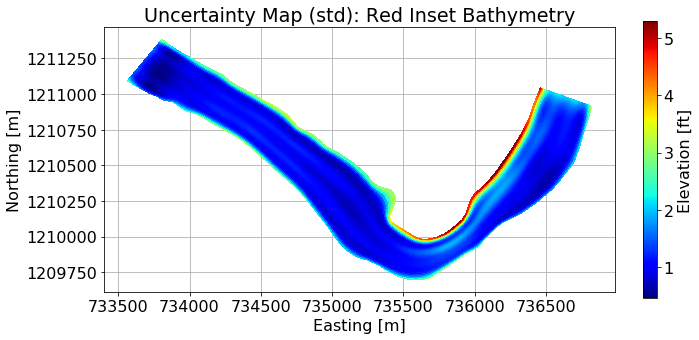

In [24]:
#fig = plt.figure(figsize=(10., 10.), dpi=300)
fig = plt.figure(figsize=(10., 10.))
ax = plt.gca()
im = plt.tripcolor(meshnode[:, 0], meshnode[:, 1], triangles, post_diagv.reshape(-1), cmap=plt.get_cmap('jet'), label='_nolegend_')
ax.set_xlabel("Easting [m]")
ax.set_ylabel("Northing [m]")
plt.gca().set_aspect('equal', adjustable='box')
cbar = plt.colorbar(im, fraction=0.025, pad=0.05)
cbar.set_label('Elevation [ft]')
plt.rcParams['axes.axisbelow'] = True
plt.rc('axes', axisbelow=True)
plt.grid()
ax.set_axisbelow(True)
plt.tight_layout()
ax.set_title('Uncertainty Map (std): Red Inset Bathymetry')
#plt.savefig('./bathymetry_postv.png', dpi=300, bbox_inches='tight', pad_inches=0.0)
# plt.show()
#plt.close(fig)



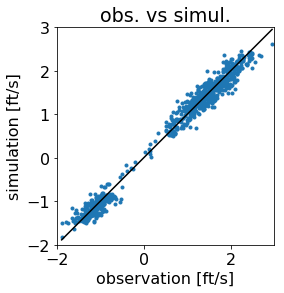

In [25]:
nobs = prob.obs.shape[0]
fig = plt.figure()
plt.title('obs. vs simul.')
plt.plot(prob.obs, simul_obs, '.')
plt.xlabel('observation [ft/s]')
plt.ylabel('simulation [ft/s]')
minobs = np.vstack((prob.obs, simul_obs)).min(0)
maxobs = np.vstack((prob.obs, simul_obs)).max(0)
plt.plot(np.linspace(minobs, maxobs, 20), np.linspace(minobs, maxobs, 20), 'k-')
axes = plt.gca()
axes.set_xlim([math.floor(minobs), math.ceil(maxobs)])
axes.set_ylim([math.floor(minobs), math.ceil(maxobs)])
axes.set_aspect('equal', adjustable ='box')
#fig.savefig('obs.png', dpi=fig.dpi)
# plt.show()
#plt.close(fig)